In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import yaml

In [4]:
import os 

os.chdir('E://bond-dex/bond-amm-research/')

In [5]:
import matplotlib.pyplot as plt
import scienceplots
 
plt.style.use('ieee')

In [6]:
plt.rcParams["figure.figsize"] = (5,3)

**<font size=3, color='red'> Constant Sum </font>** 

$\Large K x^{\alpha} + y^{\alpha} = \mathcal{C}$

**<font size=3, color='red'> BondAMM curve </font>** 

$\Large K = e^{\frac{-\tau r^{\star}}{1+\tau \kappa}}$

$\Large \alpha = \frac{1}{1+\tau \kappa}$


**<font size=3, color='red'> Notional curve </font>** 

$\Large K = e^{-\tau r^{\star}}$

$\Large \alpha = 1 - \tau \kappa$


**<font size=3, color='red'> Yield curve </font>** 

$r^{\star} = 0, \kappa = 1$

$\Large K = 1$

$\Large \alpha = 1 - \tau$

In [7]:
def polybond_curve(x0, y0, x, y, tau, kappa, r_star): 
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    C = K*x0**alpha + y0**alpha 
    
    if x is not None: 
        y = (C - K*x**alpha)**(1/alpha)
    else: 
        x = ((C - y**alpha)/K)**(1/alpha)
    
    return x, y


def notional_curve(x0, y0, x, y, tau, kappa, r_star): 
    
    K = np.exp(-tau * r_star)
    alpha = 1 - tau * kappa 
    
    C = K*x0**alpha + y0**alpha 
    
    if x is not None: 
        y = (C - K*x**alpha)**(1/alpha)
    else: 
        x = ((C - y**alpha)/K)**(1/alpha)
    
    return x, y


def yield_curve(x0, y0, x, y, tau): 
    
    kappa=1
    r_star=0
    
    K = np.exp(-tau * r_star)
    alpha = 1 - tau * kappa 
    
    C = K*x0**alpha + y0**alpha 
    
    if x is not None: 
        y = (C - K*x**alpha)**(1/alpha)
    else: 
        x = ((C - y**alpha)/K)**(1/alpha)
    
    return x, y

In [8]:
x0 = 0.6
y0 = 0.4

curves = []

kappa = 0.02
r_star = 0.1

x = np.arange(0.2, 0.8, 0.01)

for tau in [0.1, 5, 10, 49]: 

    _, y1 = polybond_curve(x0, y0, x, None, tau, kappa, r_star)
    _, y2 = notional_curve(x0, y0, x, None, tau, kappa, r_star)
    _, y3 = yield_curve(x0, y0, x, None, 0.999)
    
    curves.append(
    {
        'tau': tau,
        'x': x,
        'y1': y1,
        'y2': y2,
        'y3': y3
    }
    )

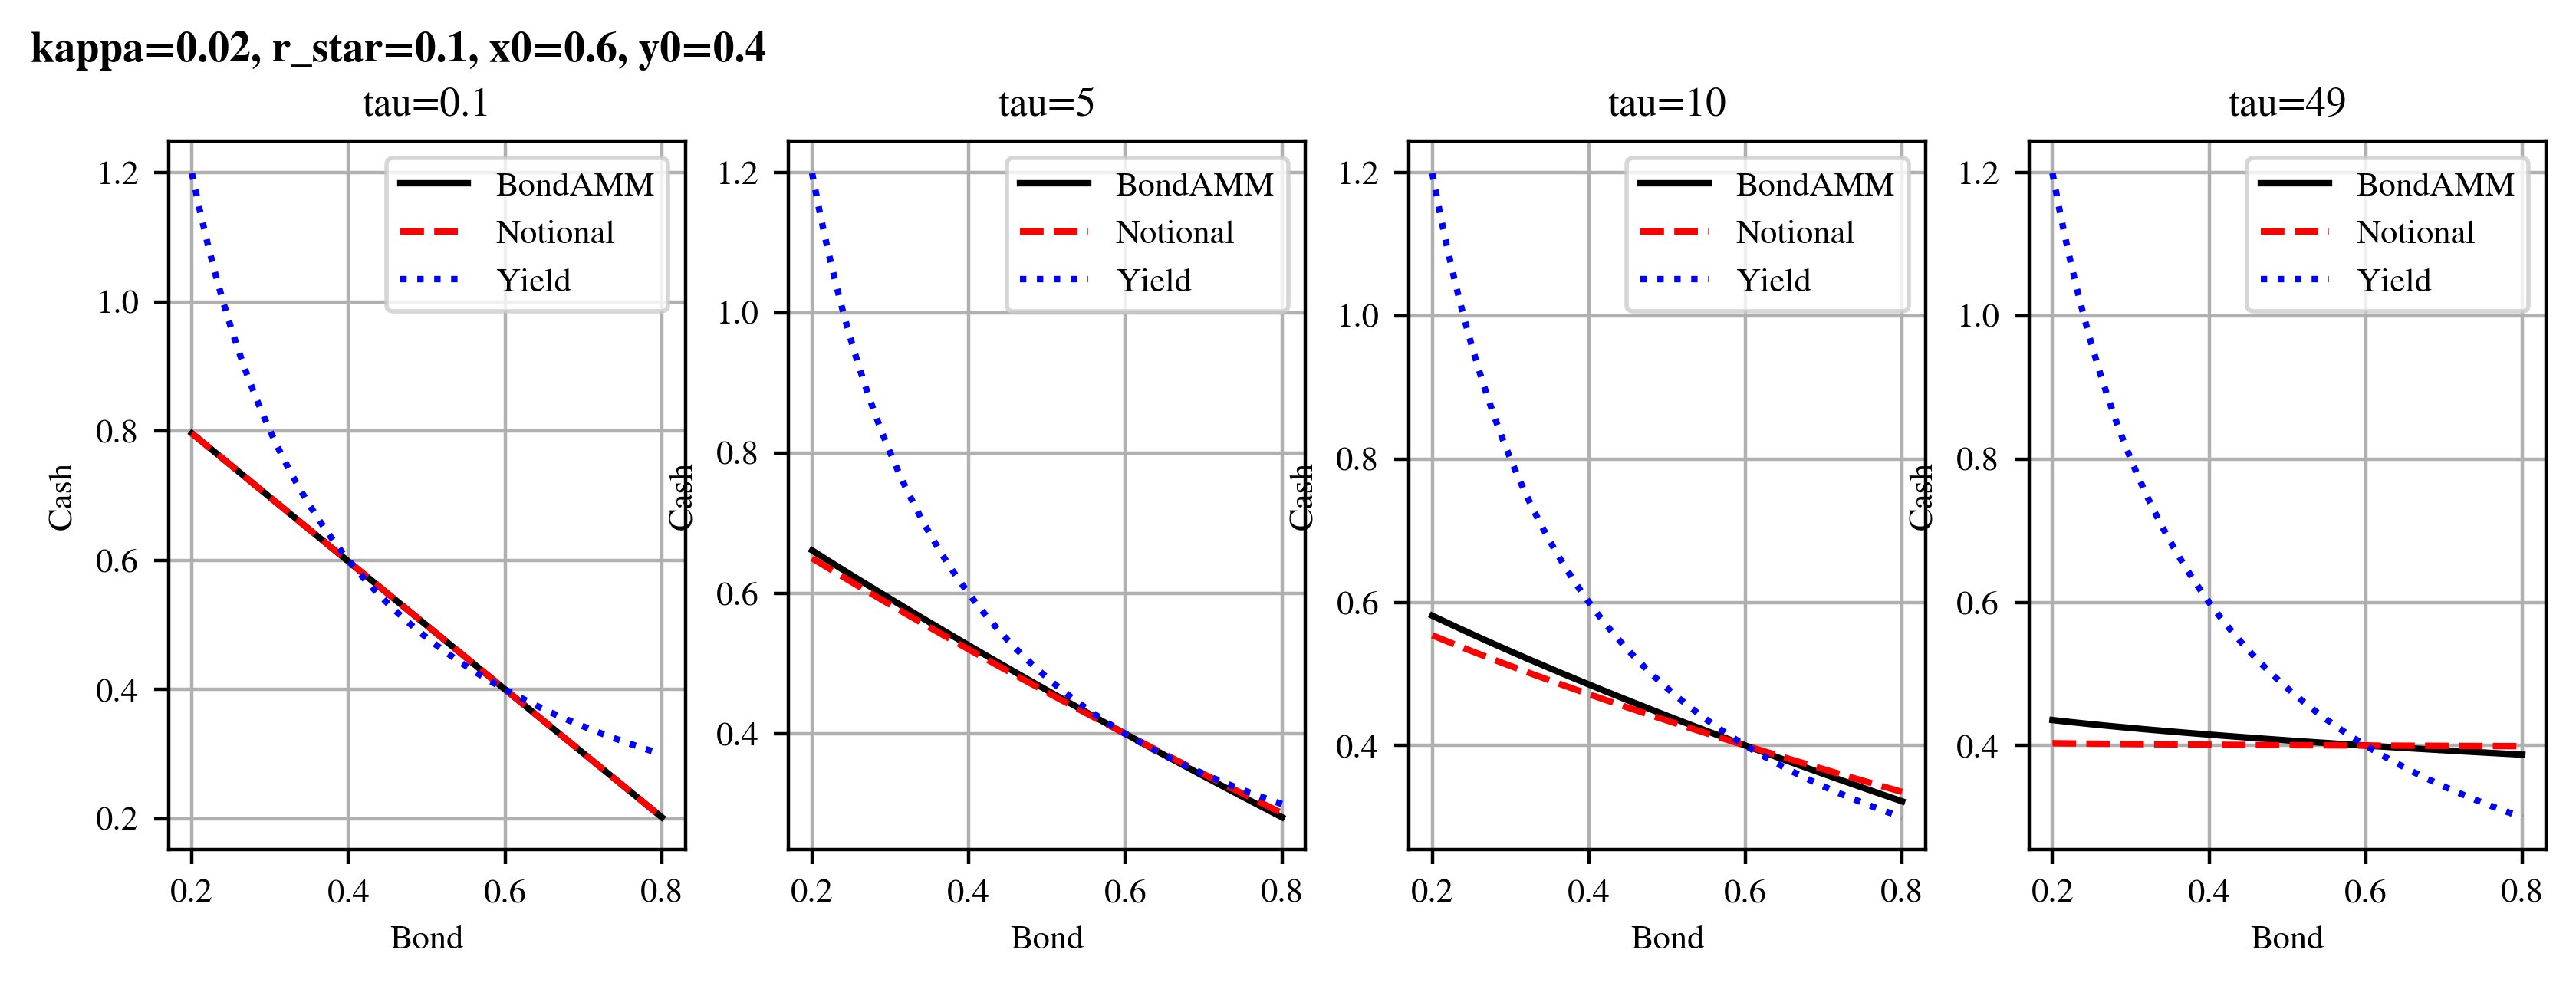

In [9]:
# plt.figure(figsize=(5, 3))

fig, axs = plt.subplots(1, 4, figsize=(10, 3), dpi=400)

for data, ax in zip(curves, axs): 
    
    x, y1, y2, y3, tau = data['x'], data['y1'], data['y2'], data['y3'], data['tau']

    ax.plot(x, y1, label='BondAMM')
    ax.plot(x, y2, label='Notional')
    ax.plot(x, y3, label='Yield')
    
    ax.set_title(f'tau={tau}')

    ax.set_xlabel('Bond')
    ax.set_ylabel('Cash')

    ax.legend()
    ax.grid()
    
fig.suptitle(f'kappa={kappa}, r_star={r_star}, x0={x0}, y0={y0}', x=0.2, y=1, fontsize=10, weight='bold')

plt.show()

In [10]:
def polybond_net_bond_price(x, y, dx, tau): 
    kappa = 0.02 
    r_star = 0.05 
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    new_x = x + dx 
    new_y = (K*x**alpha + y**alpha - K*new_x**alpha)**(1/alpha)
    
    dy = new_y - y 
    price = -dy / dx
    
    return price 


def yield_net_bond_price(x, y, dx, tau): 
    
    new_x = x + dx 
    new_y = (x**(1-tau) + y**(1-tau) - new_x**(1-tau))**(1/(1-tau))
    
    dy = new_y - y 
    
    price = -dy / dx 
    
    return price 


def notional_net_bond_price(x, y, dx, tau): 
    
    r_star = 0.05 
    kappa = 0.02 
    
    K = np.exp(-tau * r_star)
    alpha = 1 - tau * kappa 
    
    new_x = x + dx 
    new_y = (K*x**alpha + y**alpha - K*new_x**alpha)**(1/alpha)
    
    dy = new_y - y 
    price = -dy / dx
    
    return price 

In [11]:
import json


def read_data(folder_dir, file_path):
    file_path = os.path.join(folder_dir, file_path)

    with open(file_path, 'r') as file:
        data = json.load(file)

    _df = pd.DataFrame(data['value'])
    _df['timestamp'] = data['timestamp']
    _df['pool_address'] = data['pool_address']

    return _df


def calculate_pv(values, rates, maturities):
    return values * np.exp(-rates * maturities / (365 * 24 * 60))


def make_stats(df, initial_cash, liability_price=None):
    
    df = df[~df.last_price.isna()].reset_index(drop=True)

    df['pv_net_bond'] = calculate_pv(df.net_bond.values, df.interest_rate.values, df.time_to_maturity.values)

    df['pv_bond'] = calculate_pv(df.bond.values, df.interest_rate.values, df.time_to_maturity.values)

    df['pool_value'] = df['cash'] + df['pv_bond']
    df['net_pool_value'] = df['cash'] + df['pv_net_bond']
    df['future_pool_value'] = df['cash'] + df['net_bond']
    df['PnL'] = df['net_pool_value'] - initial_cash
    df['quantity_inventory_ratio'] = df['bond'] / (df['bond'] + df['cash'])
    df['value_inventory_ratio'] = df['pv_bond'] / (df['pv_bond'] + df['cash'])
    
    df['tau'] = df['time_to_maturity'] / (365 * 24 * 60)
    df['timestamp_year'] = df['timestamp'] / (365 * 24 * 60)
    
    if liability_price is not None: 
        df['liability'] = liability_price(df.bond, df.cash, df.net_bond, df.tau) * df.net_bond
        
        df.liability = np.where(df.liability.isna() | (df.liability + df.cash < 0), -df.cash, df.liability)
        
        df['solvency'] = (df.cash + df.liability) / df.cash
        df['present_pnl'] = (df.cash + df.liability) / initial_cash
        df['mature_pnl'] = (df.cash + df.net_bond) / initial_cash
    
    gamma = 0.1
    kappa = 0.02 
    
    df['fee'] = abs(gamma * kappa * np.log(df.pv_bond / df.cash))
    
    df['interest_rate_adjusted'] = df.fee + df.interest_rate
    
    df['price_adjusted'] = np.exp(-(-np.log(df['last_price']) / df.tau + df.fee) * df.tau)

    return df

In [12]:
def polybond_net_bond_price2(x, y, dx, tau): 
    kappa = 0.02 
    r_star = 0.05 
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    if dx == 0: 
        return K*(x/y)**(alpha-1)
    
    print(K, alpha)
    
    new_x = x + dx 
    new_y = (K*x**alpha + y**alpha - K*new_x**alpha)**(1/alpha)
    
    print(new_x, new_y)
    
    dy = new_y - y 
    price = -dy / dx
    
    if dx == 0: 
        return 
    
    return price 

In [13]:
def extract_combo(combo):
    df = combo['df']
    color = combo['color'] 
    label = combo['label']
    lty = combo['linestyle']
    return df, color, label, lty

In [14]:
def plot_x_time(combo, col_name, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0):
    
    df, color, label, lty = extract_combo(combo)

    fig, ax = plt.subplots()

    ax.plot(df.timestamp_year, df[col_name], color=color, linestyle=lty) 

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xpercent: 
        xticks = ax.get_xticks()
        
        ax.set_xticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in xticks])
    
    if ypercent: 
        yticks = ax.get_yticks()
        
        ax.set_yticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in yticks])

    ax.grid()
    
    return fig

def plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0): 
    
    fig, ax = plt.subplots()
    
    for combo in combos:
        
        df, color, label, lty = extract_combo(combo)

        ax.plot(df.timestamp_year, df[col_name], color=color, linestyle=lty, label=label) 

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    if xpercent: 
        xticks = ax.get_xticks()
        
        ax.set_xticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in xticks])
    
    if ypercent: 
        yticks = ax.get_yticks()
        
        ax.set_yticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in yticks])

    ax.grid()
    
    ax.legend()
    
    return fig

def plot_x_time3(df, col_names, col_labels, colors, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0):
    
    fig, ax = plt.subplots()
    
    for col, label, color in zip(col_names, col_labels, colors): 
        ax.plot(df.timestamp_year, df[col], label=label, color=color)
    
    if xpercent: 
        xticks = ax.get_xticks()
        
        ax.set_xticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in xticks])
    
    if ypercent: 
        yticks = ax.get_yticks()
        
        ax.set_yticklabels([f'{int(round(tick * 100, unit_round) * 10**unit_round)/10**unit_round}%' for tick in yticks])
        
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.grid()
    
    ax.legend()
    
    return fig

In [15]:
import matplotlib.pyplot as plt
import scienceplots
 
plt.style.use('ieee')

In [16]:
version = 8

polybond = read_data(f'data/tracking-v{version}/v1.1/', 'ALL_INFORMATION.json')
yield_bond = read_data(f'data/tracking-v{version}/yield_v1/', 'ALL_INFORMATION.json')
notional = read_data(f'data/tracking-v{version}/notional-v2/', 'ALL_INFORMATION.json')

In [17]:
polybond = make_stats(polybond, initial_cash=0.5, liability_price=polybond_net_bond_price)
yield_bond = make_stats(yield_bond, initial_cash=0.5, liability_price=yield_net_bond_price)
notional = make_stats(notional, initial_cash=0.5, liability_price=notional_net_bond_price)

In [18]:
plt.rcParams["figure.figsize"] = (5,3)

In [19]:
combos = [
    {
        'df': polybond, 
        'label': 'BondMM', 
        'color': 'tab:green', 
        'linestyle': 'solid'
    }, 
    {
        'df': notional, 
        'label': 'Notional Finance', 
        'color': 'tab:red',
        'linestyle': 'solid'
    },
    {
        'df': yield_bond, 
        'label': 'Yield Protocol', 
        'color': 'tab:blue',
        'linestyle': 'solid'
    }
]

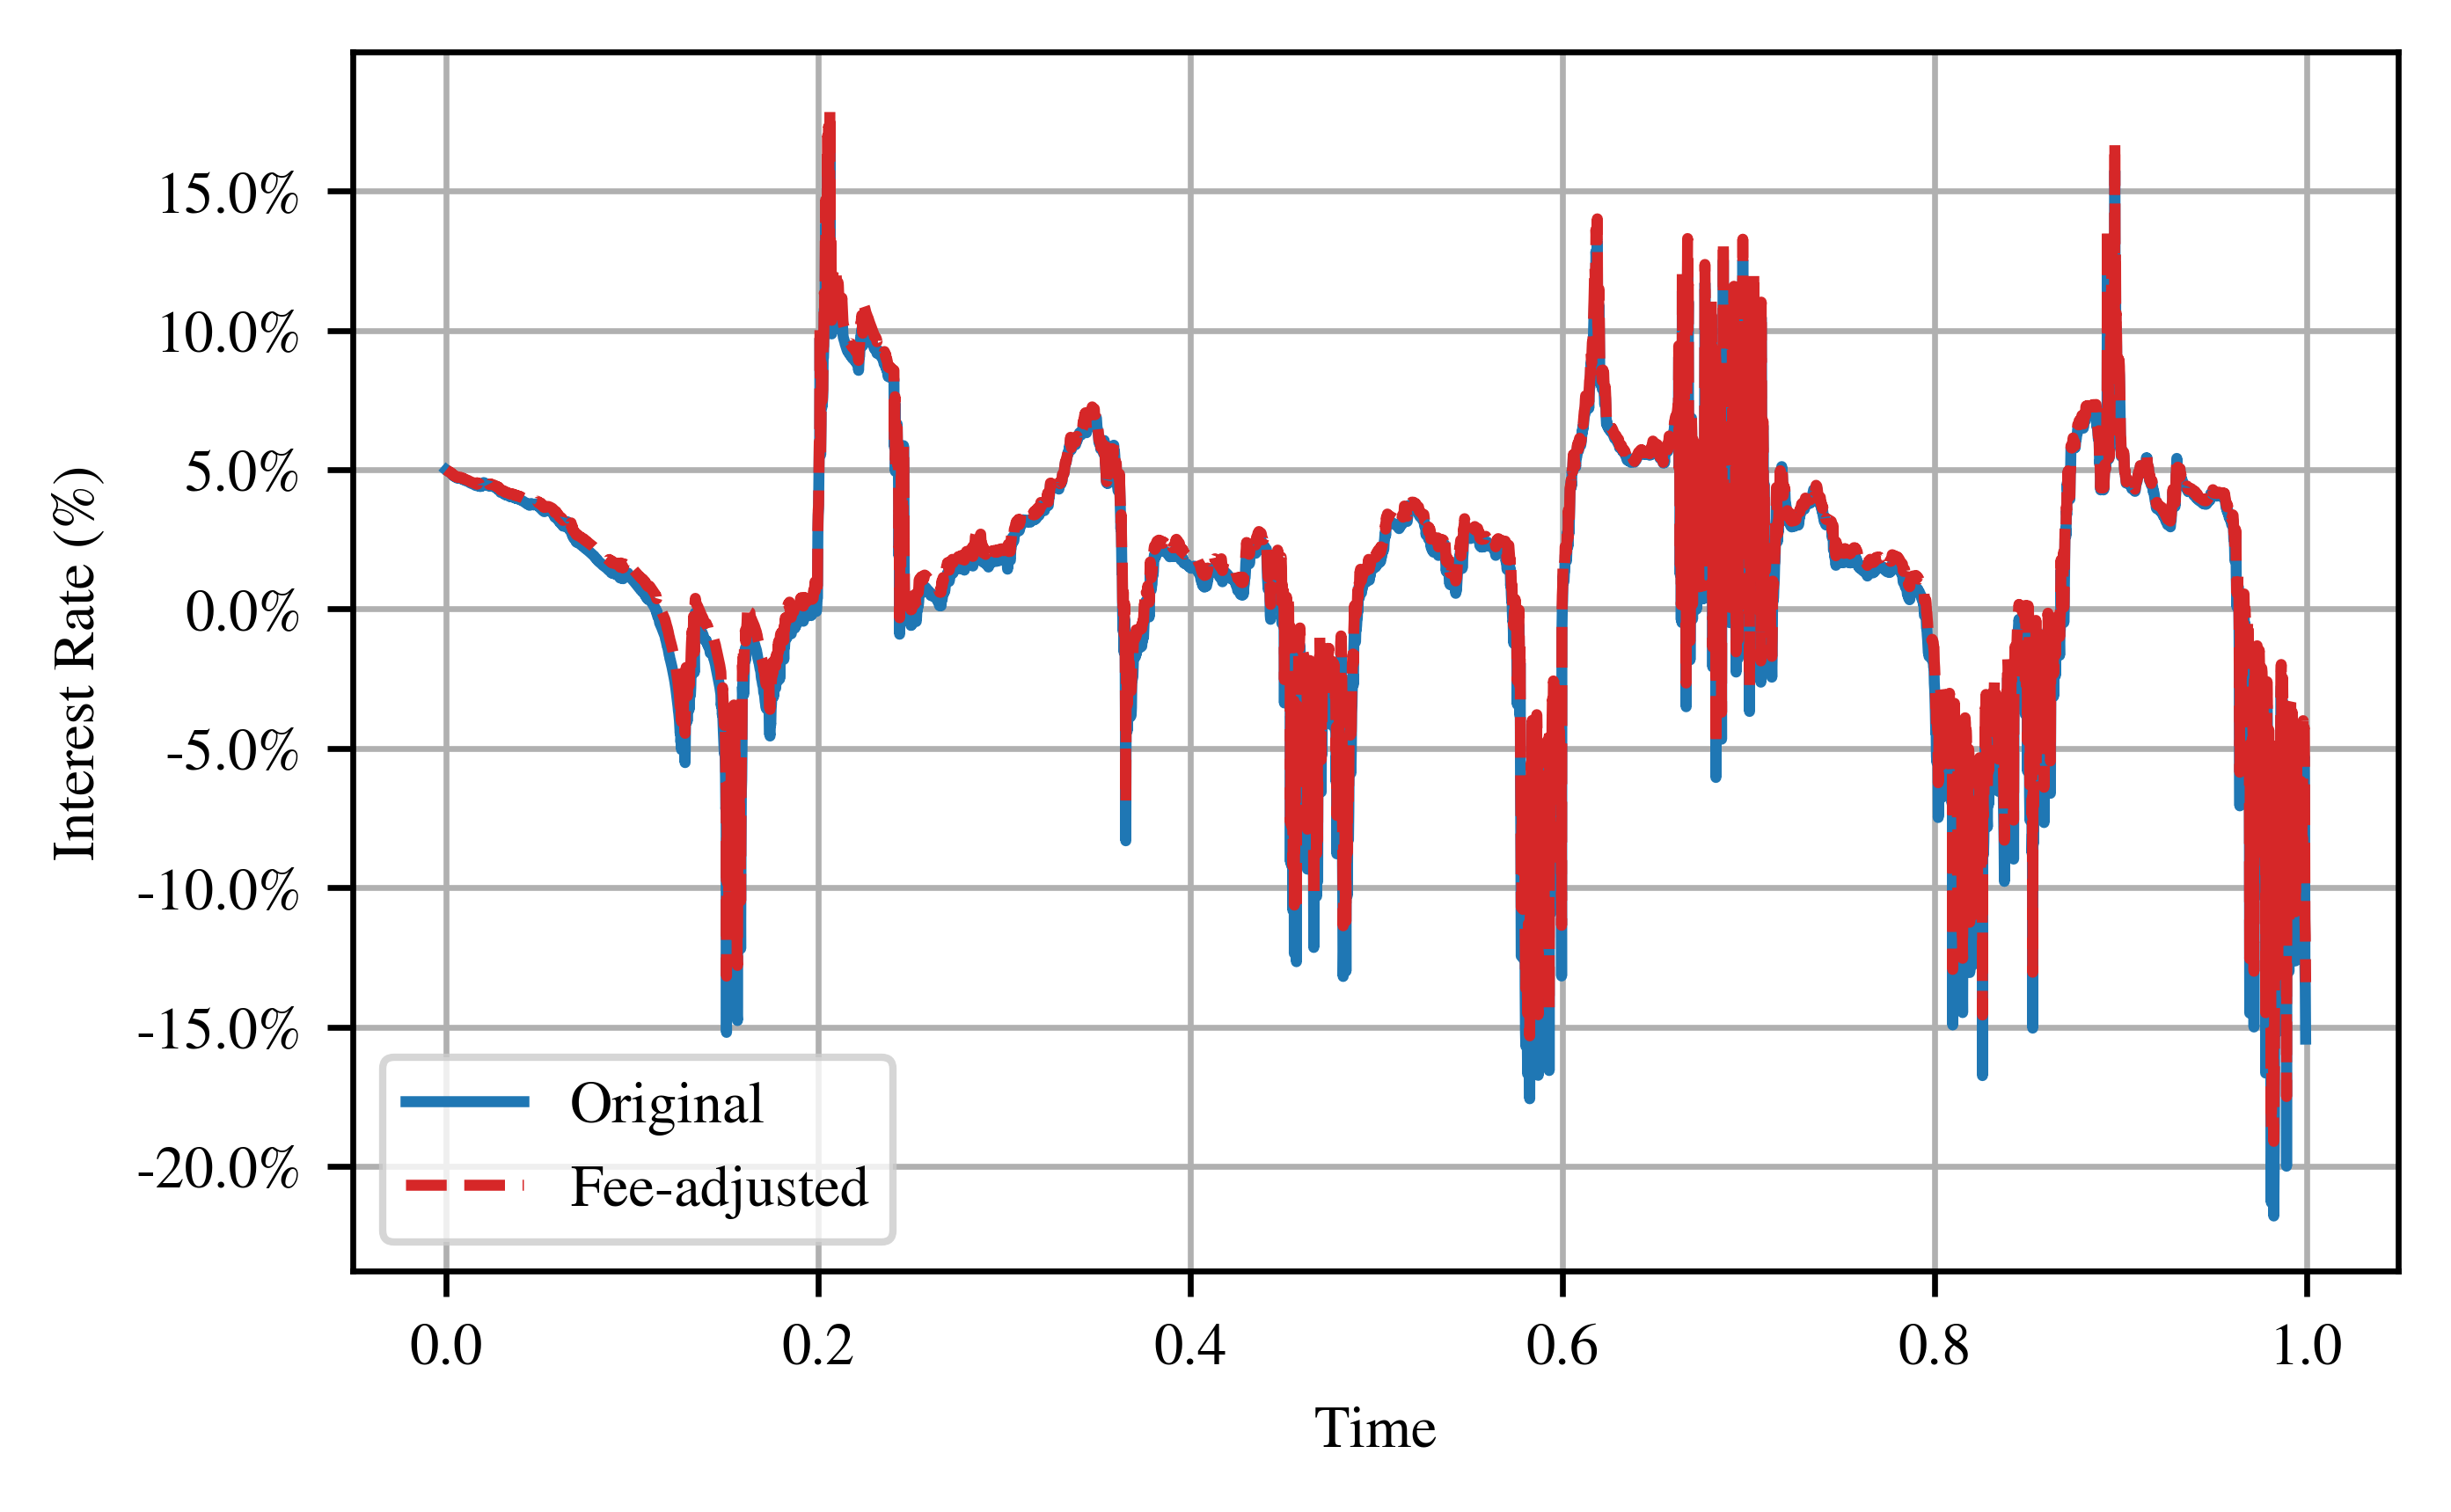

In [20]:
xlabel = 'Time'
ylabel = 'Interest Rate (%)'
col_name = 'interest_rate'

fig = plot_x_time3(polybond, ['interest_rate', 'interest_rate_adjusted'], 
             ['Original', 'Fee-adjusted'],
             ['tab:blue', 'tab:red'],
             xlabel, ylabel,
             ypercent=True, unit_round=1)

fig.savefig(f'images/v{version}/8.Interest_rate_adjusted_gamma=0.1.png', dpi=400, transparent=True)

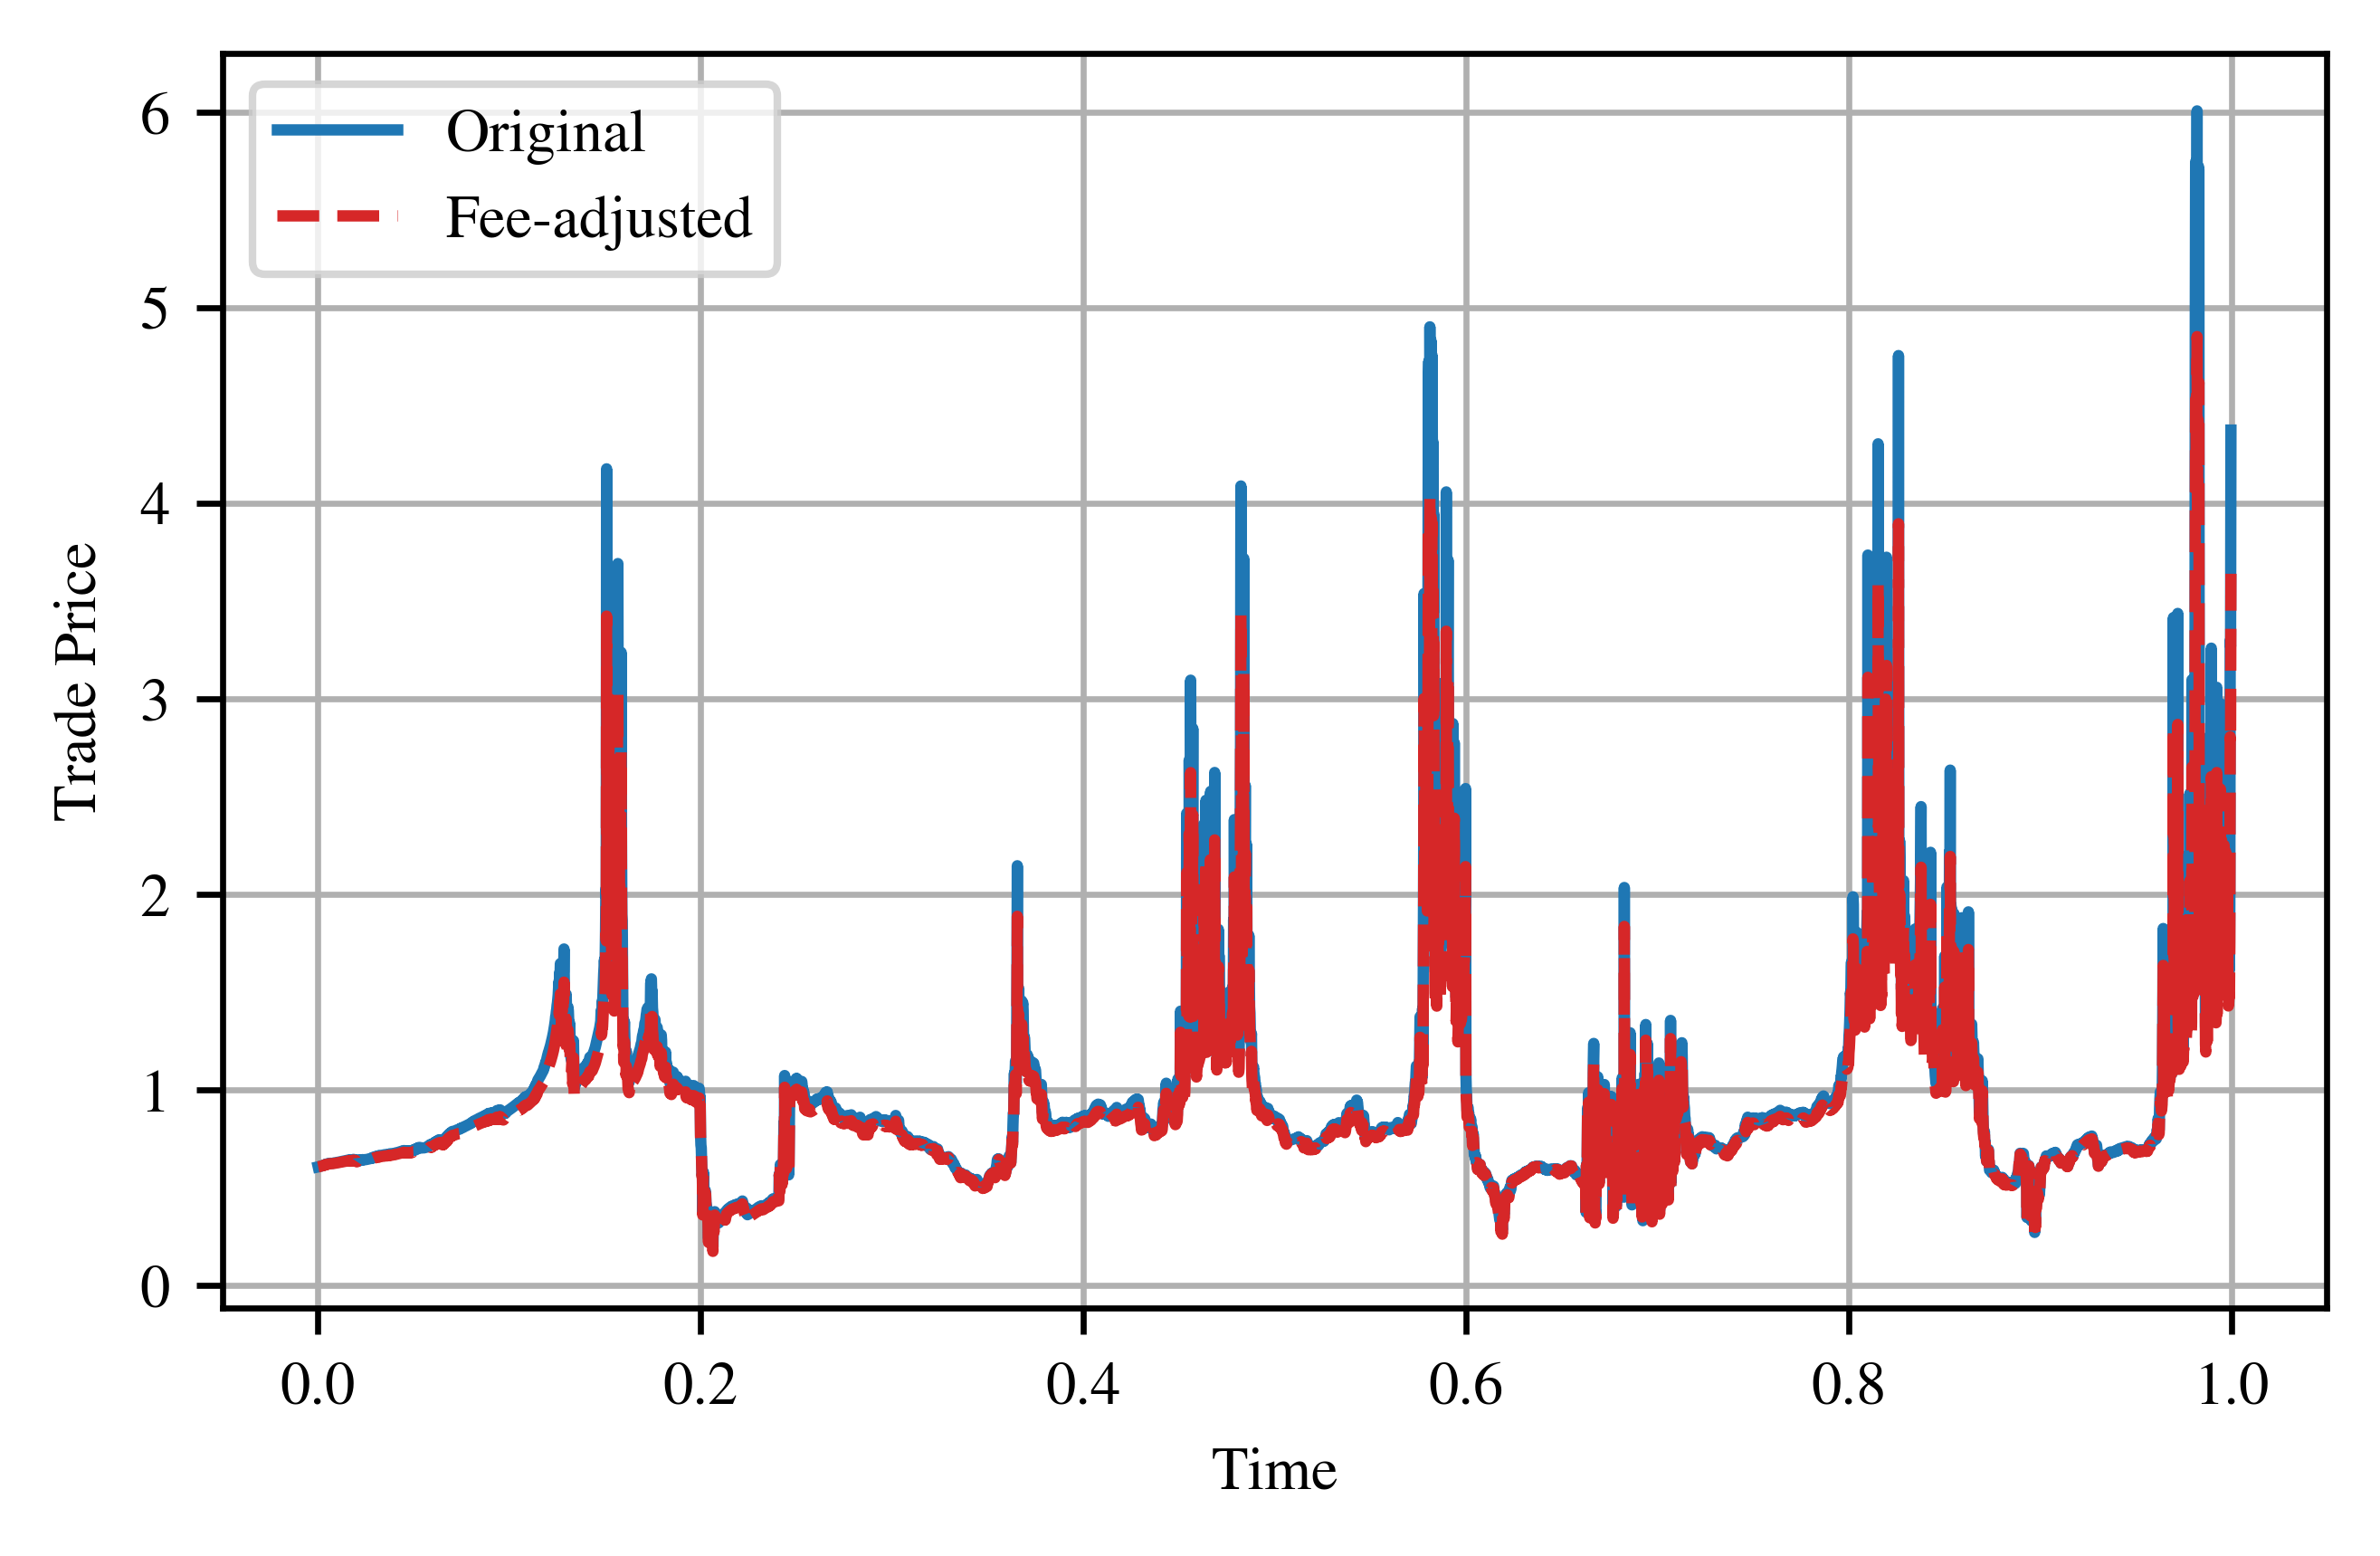

In [21]:
xlabel = 'Time'
ylabel = 'Trade Price'

fig = plot_x_time3(polybond, ['last_price', 'price_adjusted'], 
             ['Original', 'Fee-adjusted'],
             ['tab:blue', 'tab:red'],
             xlabel, ylabel)

fig.savefig(f'images/v{version}/9.Trade_price_adjusted_gamma=0.1.png', dpi=400, transparent=True)

In [22]:
xlabel = 'Time'
ylabel = 'Trade Price'
col_name = 'last_price'

index = 1

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=False)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=False)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=False)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [23]:
xlabel = 'Time'
ylabel = 'Interest Rate (%)'
col_name = 'interest_rate'

index = 2

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True, )

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [24]:
xlabel = 'Time'
ylabel = 'Bond-Value Proportion (%)'
col_name = 'value_inventory_ratio'

index = 3 

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [25]:
xlabel = 'Time'
ylabel = 'Bond-Quantity Proportion (%)'
col_name = 'quantity_inventory_ratio'

index = 4

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [26]:
xlabel = 'Time'
ylabel = 'Solvency (%)'
col_name = 'solvency'

index = 5

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [27]:
xlabel = 'Time'
ylabel = 'Present PnL (%)'
col_name = 'present_pnl'

index = 6

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [28]:
xlabel = 'Time'
ylabel = 'Mature PnL (%)'
col_name = 'mature_pnl'

index = 7

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=True, unit_round=1)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [34]:
xlabel = 'Time'
ylabel = '# Run of out liquidity'
col_name = 'n_revert'

index = 10

fig1 = plot_x_time(combos[0], col_name, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0)

fig1.savefig(f'images/v{version}/{index}.BondMM_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig2 = plot_x_time2(combos[:2], col_name, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0)

fig2.savefig(f'images/v{version}/{index}.BondMM_notional_{ylabel}.png', dpi=400, transparent=True)

plt.close()

fig3 = plot_x_time2(combos, col_name, xlabel, ylabel, xpercent=False, ypercent=False, unit_round=0)

fig3.savefig(f'images/v{version}/{index}.yield_{ylabel}.png', dpi=400, transparent=True)

plt.close()

In [29]:
YEAR_LENGTH = 365*24*60

In [321]:
input_df = pd.read_csv('data/input/single_trade2.csv')

In [323]:
input_df['net_volume'] = input_df.cash_volume * input_df.action.map({'borrow': -1, 'lend': 1})

In [329]:
input_df['timestamp_year'] = input_df['timestamp'] / YEAR_LENGTH

In [334]:
input_df['cum_net_volume'] = 0.5 + input_df.net_volume.cumsum()

In [338]:
input_df['order_size_pct'] = input_df.net_volume / input_df['cum_net_volume']

<Axes: xlabel='timestamp_year', ylabel='cum_net_volume'>

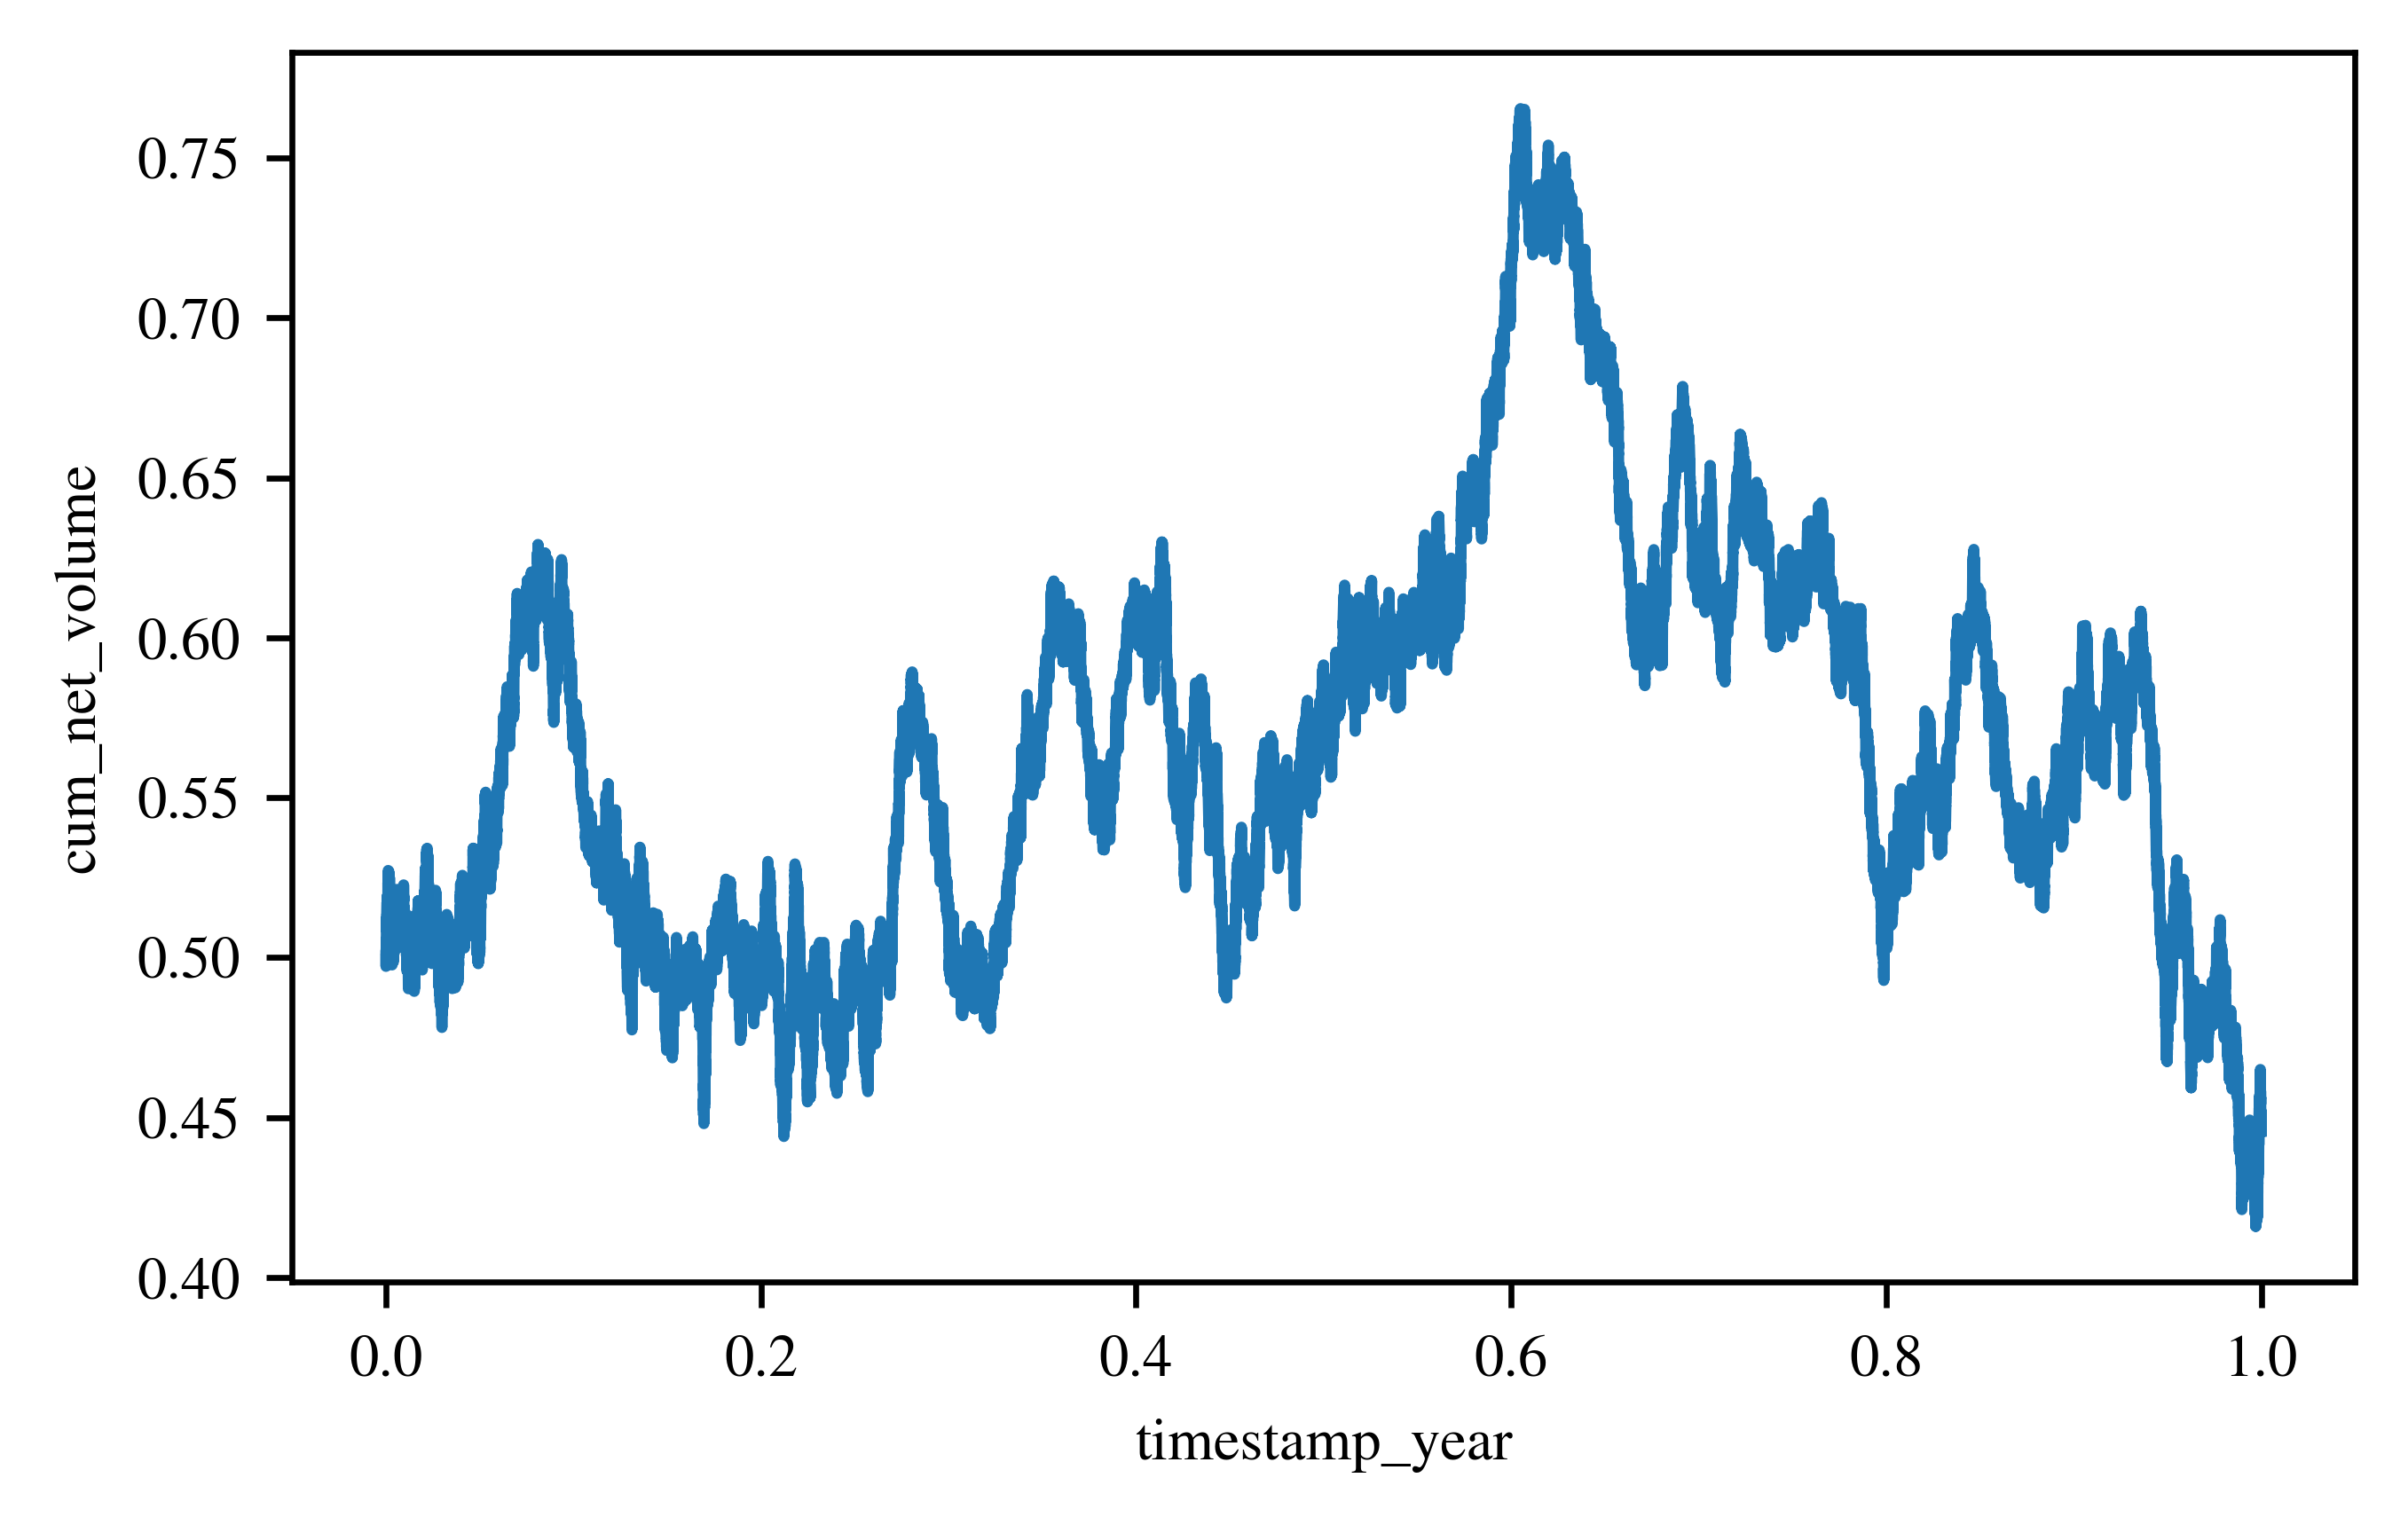

In [337]:
sns.lineplot(data=input_df, x='timestamp_year', y='cum_net_volume', color='tab:blue')

<Axes: xlabel='timestamp_year', ylabel='order_size_pct'>

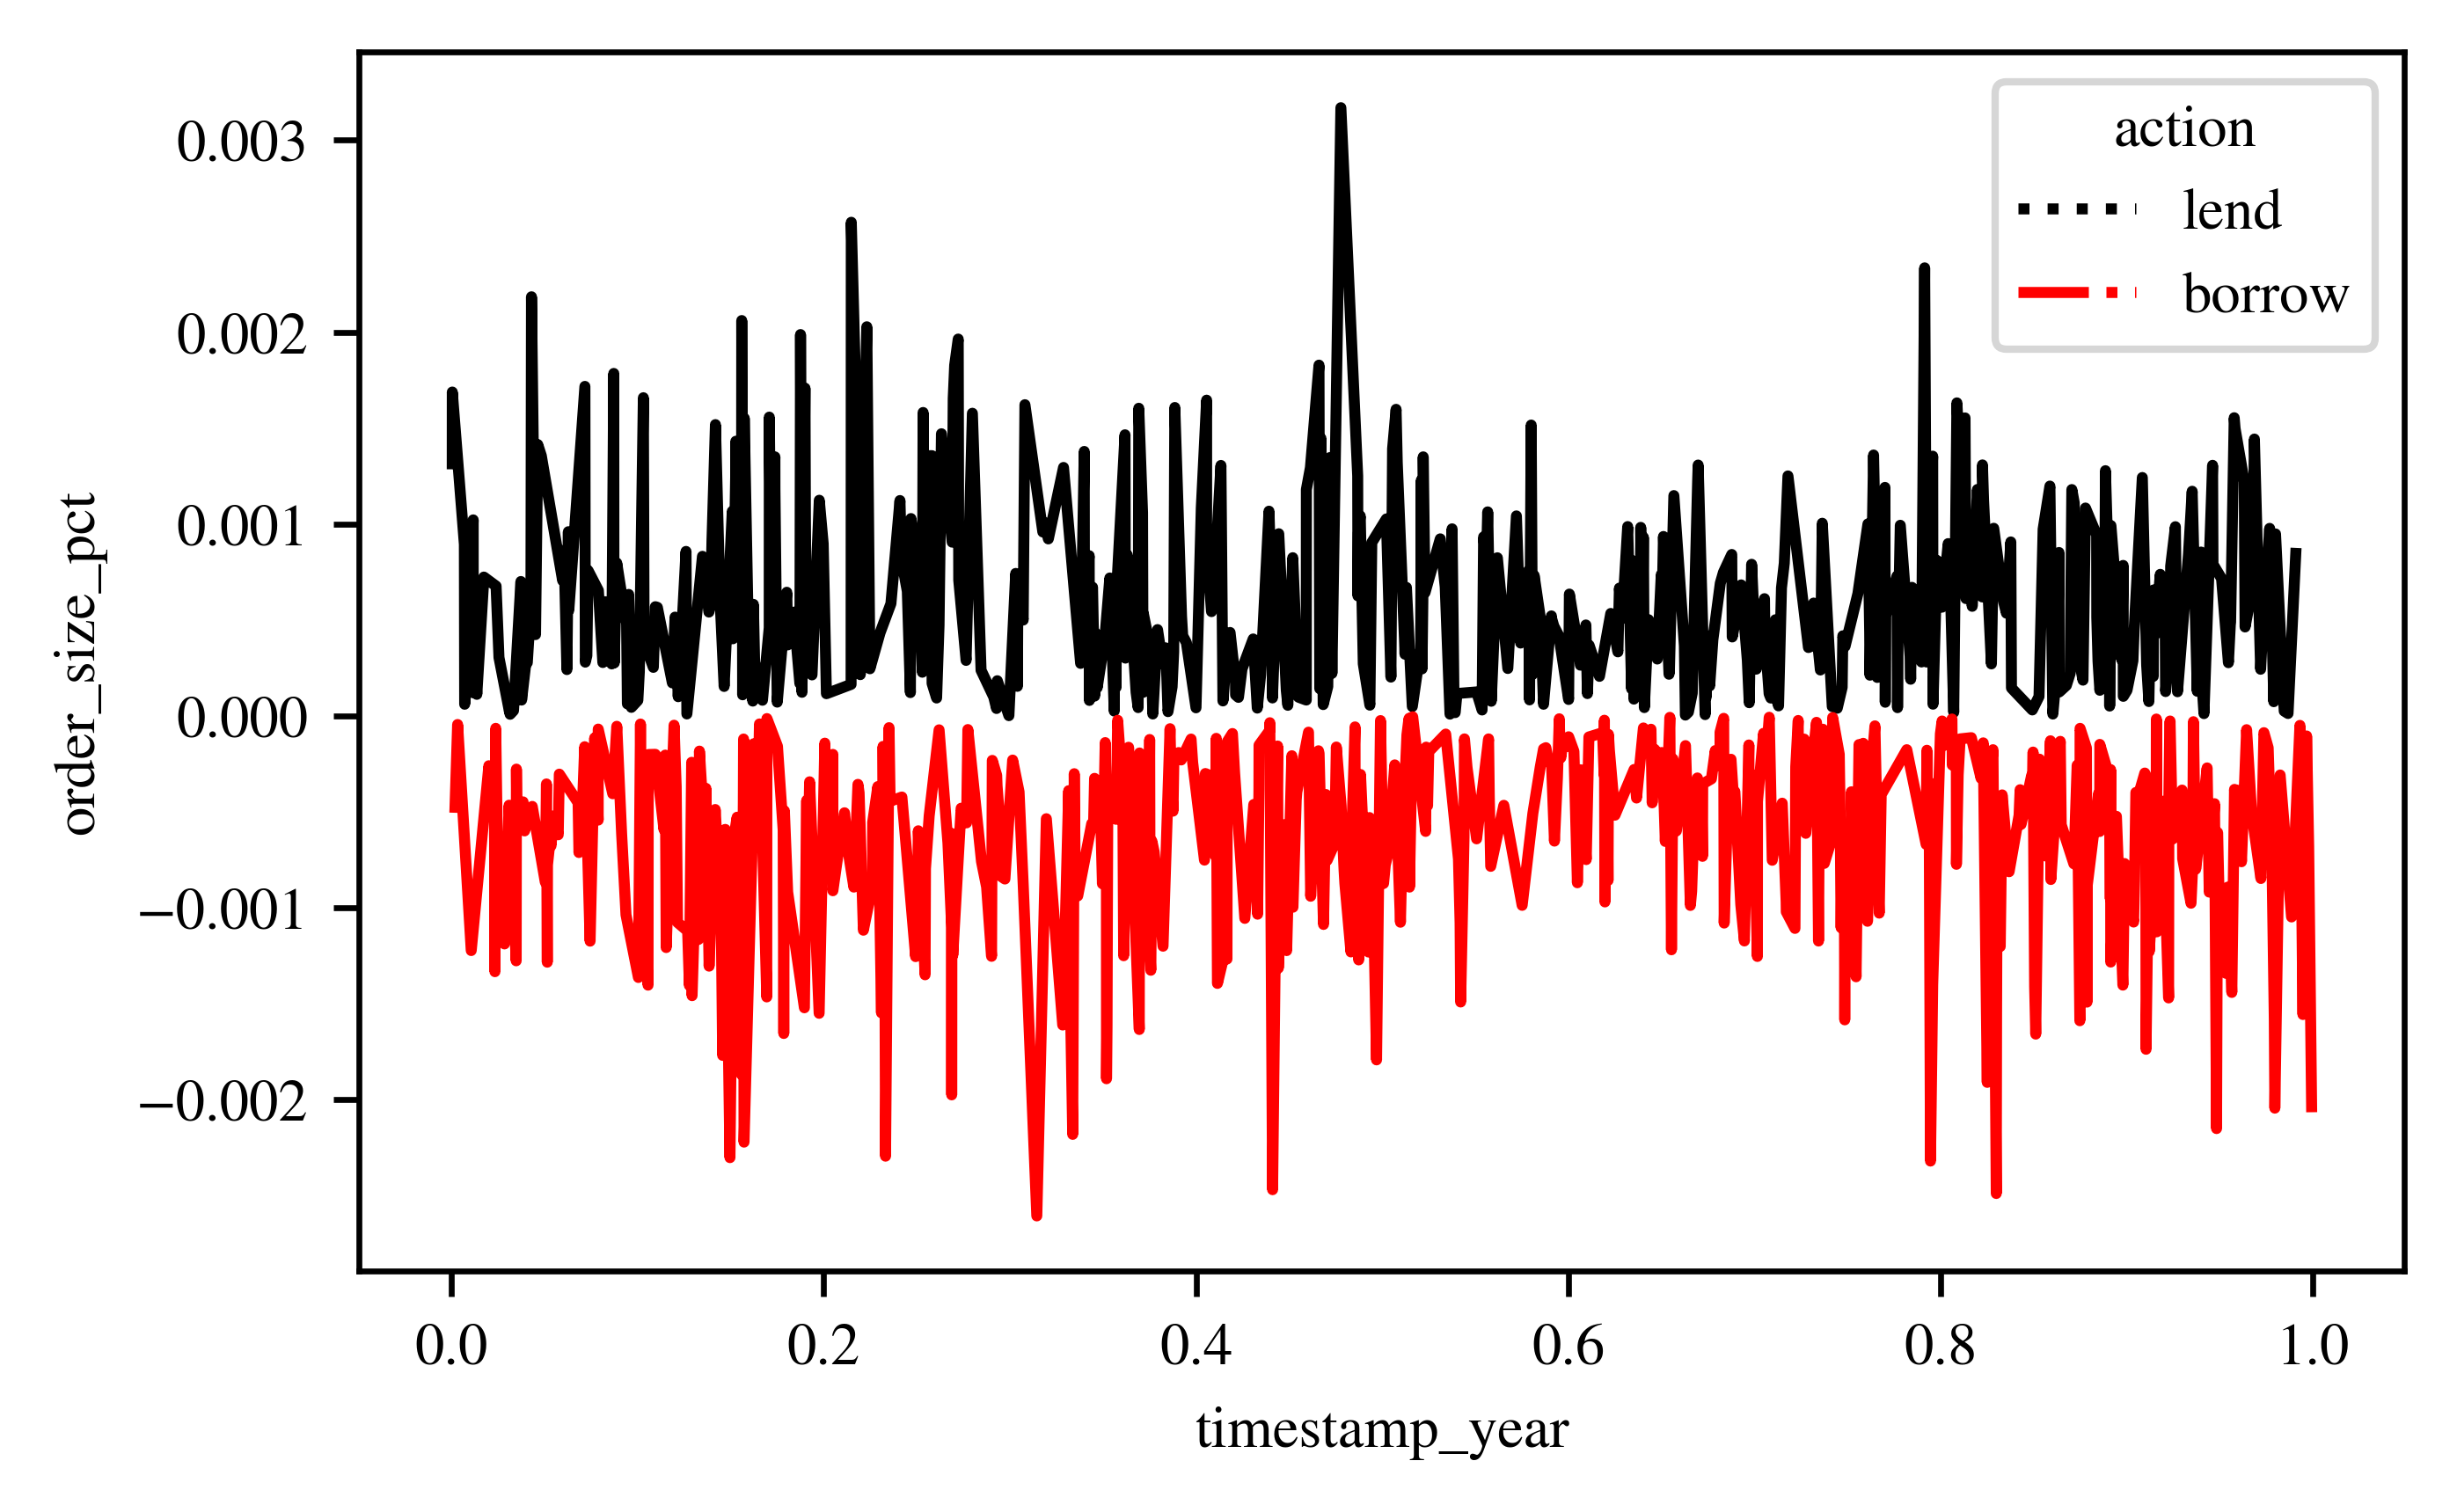

In [339]:
sns.lineplot(data=input_df.sample(1000), x='timestamp_year', y='order_size_pct', hue='action')